
<img src=https://global-uploads.webflow.com/636bdbebfc681f083e923f81/63861eaf1256c85ceff3c32c_6138752e55f82a0d6b6902cc_Parsing%2520definition-min.jpeg width="800" height="350">

<img src=https://tomassetti.me/wp-content/uploads/2017/02/lexer-parser-center-1030x187.png width="800" height="450">  

<img src=https://vaclavkosar.com/images/transformer-tokenization-and-embeddings.drawio.svg width="400" height="150">    

# Web Scraping

In [1]:
import requests
import pandas as pd

In [2]:
import time
import numpy as np
import os
from bs4 import BeautifulSoup
import re

In [3]:
# CPU USAGE

import multiprocessing

num_cores = multiprocessing.cpu_count()
cores_you_need_to_be_free = 2
cores_to_use = num_cores - cores_you_need_to_be_free
print('cores available:', num_cores,
      '\ncores to be used:', cores_to_use
     )

cores available: 8 
cores to be used: 6


### Define a function

In [4]:
def extract_artist (url):
    
    """ function return artist name and links to download lyrics """
    links=[]
    artist_list = []
    link = url
    headers = {'User-agent': 'Mozilla/5.0 (X11; Linux i686; rv:2.0b10) Gecko/20100101 Firefox/4.0b10'}
    
# extract artist page and store in txt file 

    if os.path.exists('html_data/artist.txt'):
        os.remove('html_data/artist.txt')
        
    response =requests.get(url=link, headers=headers)
    if response != 200:
        print(response.status_code)
    with open('html_data/artist.txt', 'a') as file:
        file.write(response.text)
    time.sleep(2)
            
# open the file created and sparse data with beautiful soup

    with open ('html_data/artist.txt') as file:
        artist_soup = BeautifulSoup(file, 'html.parser')
        
# Extract link to lyrics
    if links:
        links=[]
        print('link list has been emptied')
    else:
        print('start empty list to store links to songs')
    
    for lk in artist_soup.body.find_all('strong'): ## pay attention html source code
        if lk.a is not None:
            links.append(lk.a['href'])
            
# Extract artist 
    if artist_list:
        artist_list = []
        print('artist list has been emptied')
    else:
        print('start empty list to store artist')
    for artist in artist_soup.find_all(class_="artist"):
        artist_list.append(artist.text)
            
# return artist
    return artist_list[0], links
    

In [5]:
def extract_lyrics (link):
    
    """ 
    function return the lyrics of the artists """
    
    URL= 'https://www.lyrics.com'
    links = link
    headers = {'User-agent': 'Mozilla/5.0 (X11; Linux i686; rv:2.0b10) Gecko/20100101 Firefox/4.0b10'}
    
   #check if file exist - if yes  suppress it 

    if os.path.exists('html_data/songs_html.txt'):
        os.remove('html_data/songs_html.txt')
        
     # download lyrics 
    
    for i in range(0,len(links)):
        
        if len(links)<=100:
            response =requests.get(url=URL+links[i], headers=headers)
            if response.status_code != 200:
                print (response.status_code)
            with open('html_data/songs_html.txt', 'a') as file:
                file.write(response.text)
            time.sleep(2)
        else:
            if i <= 100:
                response =requests.get(url=URL+links[i], headers=headers)
                if response.status_code != 200:
                    print(response.status_code)
                with open('html_data/songs_html.txt', 'a') as file:
                    file.write(response.text)
                time.sleep(2)
                
                
    # read lyrics with Beautiful soup 
    
    with open ('html_data/songs_html.txt') as file:
        song_soup = BeautifulSoup(file, 'html.parser')
        
    # Extract lyrics in a list 
    lyrics=[]
    for song in song_soup.find_all('pre', id='lyric-body-text'): ## pay attention html source code
        #lyric = song.find("pre").get_text()
        n_jobs=cores_to_use
        lyrics.append(song.text)
        
    return lyrics
    

In [6]:
def create_dataframe(artist, lyrics, df):
    
    """ Update dataframe with artist name and Lyrics 
         Return dataframe """
        
    da = pd.DataFrame({'artist':artist, 'lyrics':lyrics})
       
    df = pd.concat([da, df], ignore_index=True)
    
    return df

In [7]:
def extract_artist_lyrics(url_list):
    """ take list of artist webpage links 
    and return a dataframe with artist name and 
    lyrics
    
    Raise an error if argument is not a list """
    
    data = pd.DataFrame(columns=['artist', 'lyrics'])
    dat_link = pd.DataFrame(columns=['artist', 'lyrics'])
    
    if not isinstance(url_list, list):
        raise TypeError("Argument must be a list.")
        
    else:
        
        for link in (url_list):
            # --- extract the artist name, 
            # --- and link to lyrics 
            artist , lk_lyrics = extract_artist (link)
            # --- extract lyrics 
            lyric = extract_lyrics (lk_lyrics)
            # --- update dataframe with name of artist and lyrics
            data = create_dataframe(artist, lyric,  data)
            dat_link = create_dataframe(artist, lk_lyrics, dat_link)
            
        
    return data, dat_link
        

### Execute function - store data in DataFrame

In [8]:
url = ['https://www.lyrics.com/artist/Imagine-Dragons/1184089','https://www.lyrics.com/artist/Bob-Marley/2907',
        'https://www.lyrics.com/artist/Linkin-Park/447095']

In [9]:
data, lyric_link = extract_artist_lyrics(url)

200
start empty list to store links to songs
start empty list to store artist
200
start empty list to store links to songs
start empty list to store artist
200
start empty list to store links to songs
start empty list to store artist


In [10]:
len(data)

289

In [11]:
data[['artist']].value_counts()


artist         
Imagine Dragons    99
Bob Marley         96
Linkin Park        94
dtype: int64

In [12]:
#len(data[['lyrics']])#.value_counts()

In [13]:
data.to_csv('/home/ayouba/spiced/nigela-network-student-code/lyrics.csv', index = False)

In [14]:
lyric_link.to_csv('/home/ayouba/spiced/nigela-network-student-code/lyric_link.csv', index = False)

In [15]:
lyric_link.head()

,artist,lyrics
0,Linkin Park,/lyric/36341863/Linkin+Park/In+the+End
1,Linkin Park,/lyric/36341864/Linkin+Park/Numb
2,Linkin Park,/lyric/36509769/Linkin+Park/Runaway
3,Linkin Park,/lyric/36509772/Linkin+Park/Papercut
4,Linkin Park,/lyric/36509780/Linkin+Park/Points+of+Authority


### Word Classification -- TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [17]:
data = pd.read_csv('~/spiced/nigela-network-student-code/lyrics.csv')

In [18]:
data.head()

,artist,lyrics
0,Linkin Park,It starts with\n\nOne thing I don't know why\n...
1,Linkin Park,I'm tired of being what you want me to be\nFee...
2,Linkin Park,Graffiti decorations\nUnder the sky of dust\nA...
3,Linkin Park,Why does it feel like night today? \nSomething...
4,Linkin Park,Forfeit the game\nBefore somebody else\nTakes ...


In [19]:
## Define corpus and y

In [76]:
corpus = data['lyrics']
y = (['Linkin Park']* len(data.loc[data['artist'] == 'Linkin Park'])) + (['Bob Marley']* len(data.loc[data['artist'] == 'Bob Marley']))  + (['Imagine Dragons']* len(data.loc[data['artist']  == 'Imagine Dragons']))  

In [77]:
len(y)

289

In [78]:
#corpus

In [79]:
#Split data

In [80]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y, random_state = 42)

In [81]:
# use grid search to find besst parameter for alpha 

In [82]:
#alpha_range

In [83]:
pipe = Pipeline ([
    ('vectorizer', TfidfVectorizer(stop_words="english")), # do tokenisation
    ('model', GridSearchCV(MultinomialNB(), param_grid = ({'alpha': np.logspace(-4, 1)}), cv=5, scoring = 'accuracy'))  # model may be replace by Logistic Regression
]
)

In [84]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('model',
                 GridSearchCV(cv=5, estimator=MultinomialNB(),
                              param_grid={'alpha': array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.1209...
       7.19685673e-02, 9.10298178e-02, 1.15139540e-01, 1.45634848e-01,
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 7.54312006e-01, 9.54095476e-01,
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01])},
                              scoring='accuracy'))])

In [85]:
pipe.score(X_test, y_test)

0.9178082191780822

In [86]:
y_pr = pipe.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pr)

In [88]:
accuracy

0.9178082191780822

### Word Classification --  CountVectorizer followed by TfidfTransformer.

### vectorizer

In [89]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [90]:
vectorizer = CountVectorizer(stop_words="english")

In [91]:
# import all lyrics in a list 
lyrics = corpus

In [92]:
## Transform lyrics into matrix
matrix = vectorizer.fit_transform(lyrics)
#print(matrix)

In [93]:
# A matrix is dense (row-dense, column-dense) 
# if there are no zeros between two nonzero entries for every line (row, column) of this matrix

In [94]:
# sparse matrix is a special case of a matrix in which the number of zero elements is much higher than the number of non-zero elements

In [95]:
matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [96]:
## Get feature out of the vectoorizer

In [97]:
## plot features name 
# vectorizer.get_feature_names_out()

In [98]:
# create a dataframe and store matrix vector and features

In [99]:
df = pd.DataFrame(matrix.todense(), columns=vectorizer.get_feature_names_out())

In [100]:
df.head()

,27,4th,aah,abandoned,abroad,academy,accounts,accused,ache,aching,...,young,yountry,youth,yuugh,zero,zimbabwe,zion,ziya,zombie,zones
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Normalisation using TF-IDF

In [101]:
tf = TfidfTransformer()

In [102]:
transformed = tf.fit_transform(matrix)

In [103]:
## store transformed into dataFrame

In [104]:
trans_df = pd.DataFrame(transformed.todense(), columns=vectorizer.get_feature_names_out())
trans_df.head()

,27,4th,aah,abandoned,abroad,academy,accounts,accused,ache,aching,...,young,yountry,youth,yuugh,zero,zimbabwe,zion,ziya,zombie,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build Classification model

In [105]:
#data.head()

In [106]:
#X = df.values                                   # to do the prediction without TF-IDF Normalization 
X = trans_df.values                            # to do the prediction after TF-IDF Normalization 
#y = (['Imagine Dragons']* len(data.loc[data['artist'] == 'Imagine Dragons'])) + (['Linkin Park']* len(data.loc[data['artist'] == 'Linkin Park']))

In [107]:
X_train.shape

(216,)

In [108]:
len(y)

289

### Logistic regression

In [109]:
### Split data set

In [110]:

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [111]:
m = LogisticRegression()
m.fit(X_train, y_train)

LogisticRegression()

In [112]:
m.score(X_train, y_train)

1.0

In [113]:
m.score(X_test, y_test)

0.8904109589041096

### Prediction test data

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [115]:
y_pred = m.predict(X_test)

In [116]:
#y_pred = y_pred.reshape(-1, 1) -- to recreate the array  --- y_pred = np.array(y_pred.tolist()),
#y_pred = y_pred.tolist()

In [117]:
#y_pred

In [118]:
type(y_test), type(y_pred)

(list, numpy.ndarray)

In [121]:
metrics.precision_score(y_test, y_pred, pos_label='Linkin Park', average='weighted')

/home/ayouba/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'Linkin Park') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.8947652095975194

### confusion matrix

In [122]:
# Confusion matrix 
cm = metrics.confusion_matrix(y_test, y_pred)

In [123]:
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                         display_labels=m.classes_)

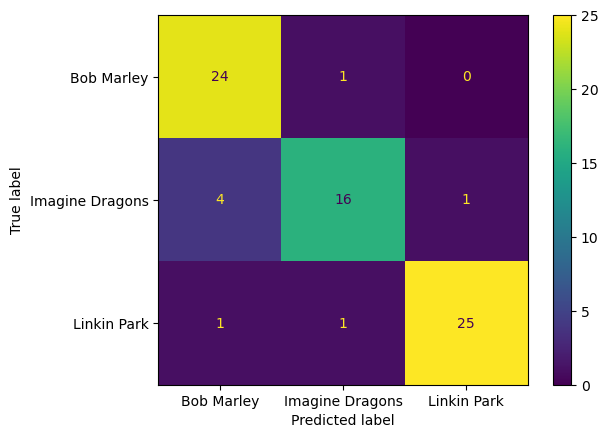

In [124]:
cm_plot.plot()

### Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [126]:
#GridSearch 

In [127]:
parameters = ({ 'n_estimators' : [2 ** i for i in range(3, 9)],
               'max_depth': [2, 4, 8, 16, 32, None]})

In [128]:
grid_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid= parameters, 
                             n_jobs=cores_to_use, cv=5, verbose = 3)

In [129]:
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256]},
             verbose=3)

In [130]:
best_param = grid_cv.best_estimator_

In [131]:
best_param.score(X_test, y_test)

0.8904109589041096

In [132]:
y_pd = best_param.predict(X_test)

In [133]:
## Confusion Matrix

In [134]:
cm_rfr =metrics.confusion_matrix(y_test, y_pd)

In [135]:
cm_dis= metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rfr, 
                                      display_labels= grid_cv.classes_)

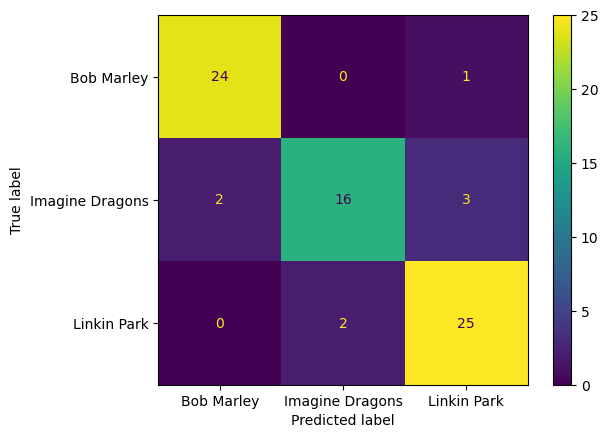

[CV 5/5] END .......max_depth=2, n_estimators=8;, score=0.581 total time=   0.0s
[CV 5/5] END ......max_depth=2, n_estimators=64;, score=0.651 total time=   0.2s
[CV 1/5] END .....max_depth=2, n_estimators=256;, score=0.727 total time=   0.7s
[CV 3/5] END ......max_depth=4, n_estimators=64;, score=0.860 total time=   0.2s
[CV 3/5] END .....max_depth=4, n_estimators=128;, score=0.860 total time=   0.4s
[CV 4/5] END .....max_depth=4, n_estimators=256;, score=0.837 total time=   0.8s
[CV 4/5] END .....max_depth=8, n_estimators=128;, score=0.930 total time=   0.4s
[CV 5/5] END .....max_depth=8, n_estimators=256;, score=0.907 total time=   0.9s
[CV 1/5] END ....max_depth=16, n_estimators=256;, score=0.886 total time=   0.9s
[CV 1/5] END .....max_depth=32, n_estimators=64;, score=0.864 total time=   0.2s
[CV 2/5] END ....max_depth=32, n_estimators=128;, score=0.907 total time=   0.4s
[CV 4/5] END ....max_depth=32, n_estimators=256;, score=0.884 total time=   0.9s
[CV 4/5] END ..max_depth=Non

In [136]:
cm_dis.plot()

### Naive Bayes

### Prediction for new lyrics

In [ ]:
pipeline = 